In [78]:
from tqdm import tqdm 

In [79]:
from functools import partial

import bpd

from jax import jit, vmap

import jax.numpy as jnp

from bpd.sample import sample_noisy_ellipticities_unclipped
from bpd.pipelines import logtarget_toy_ellips, pipeline_shear_inference_simple

from bpd.chains import run_inference_nuts

from jax import random

import matplotlib.pyplot as plt 

import numpy as np 


In [3]:
def get_mbias_mc_same(seed:int, g1=0.02, g2=0.0, n_gals=100, shape_noise=1e-3, sigma_e_int=5e-2, sigma_m=1e-5, n_samples_gals=300, n_samples_shear=1000,):
    k = random.key(seed)
    k1, k2, k3 = random.split(k, 3 )
    true_g = jnp.array([g1, g2])


    # same ellipticities with same noise, but opposite shear
    e_obs_plus, e_sheared_plus, e_int = sample_noisy_ellipticities_unclipped(
        k1, g=true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=n_gals
    )
    e_obs_minus, e_sheared_minus, _ = sample_noisy_ellipticities_unclipped(
        k1, g=-true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=n_gals
    )

    _logtarget = partial(logtarget_toy_ellips, sigma_m=sigma_m, sigma_e_int=sigma_e_int)

    k2s = random.split(k2, n_gals)

    _pipe = jit(
        partial(
            run_inference_nuts,
            logtarget=_logtarget,
            n_samples=n_samples_gals,
            initial_step_size=0.01,
            max_num_doublings=2,
            n_warmup_steps=500,
        )
    )
    pipe = vmap(_pipe, in_axes=(0, 0, 0))

    _ = pipe(k2s[:2], e_obs_plus[:2], e_int[:2])
    
    e1e2p = pipe(k2s, e_obs_plus, e_int)
    e1e2m = pipe(k2s, e_obs_minus, e_int)


    raw_pipeline = partial(
        pipeline_shear_inference_simple,
        init_g=jnp.array([0.0, 0.0]),
        sigma_e=shape_noise ,
        sigma_e_int=sigma_e_int,
        n_samples=n_samples_shear,
        initial_step_size=0.01,
    )
    pipe = jit(raw_pipeline)


    gp = pipe(k3, e1e2p)
    gm = pipe(k3, e1e2m)

    assert gp.ndim == 2
    m = (gp[..., 0].mean() - gm[..., 0].mean()) / 2 / 0.02 - 1 

    return m, gp, gm, e1e2p, e1e2m, e_sheared_plus, e_sheared_minus

In [5]:
_func = jit(
    partial(
        get_mbias_mc, shape_noise=0.1
    )
)

In [140]:
_ = _func(42)

In [141]:
# seeds = jnp.array([42, 43])
seeds = jnp.arange(100)
seeds.shape

(100,)

In [142]:
ms, gp, gm = vmap(_func)(seeds)
ms.shape, gp.shape

((100,), (100, 1000, 2))

(array([ 1.,  1.,  0.,  2.,  4., 10.,  4.,  6.,  8.,  9., 13.,  8.,  7.,
         9.,  7.,  4.,  1.,  3.,  2.,  0.,  1.]),
 array([-0.51117461, -0.50901148, -0.50684835, -0.50468523, -0.5025221 ,
        -0.50035898, -0.49819585, -0.49603273, -0.4938696 , -0.49170648,
        -0.48954335, -0.48738023, -0.4852171 , -0.48305397, -0.48089085,
        -0.47872772, -0.4765646 , -0.47440147, -0.47223835, -0.47007522,
        -0.4679121 , -0.46574897]),
 <BarContainer object of 21 artists>)

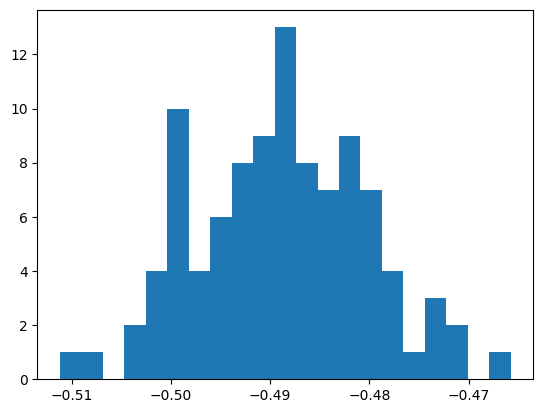

In [143]:
plt.hist(ms, bins=21)

In [144]:
ms.mean(), ms.std()

(Array(-0.48878606, dtype=float64), Array(0.00857287, dtype=float64))

In [145]:
ms.mean() / ms.std()

Array(-57.0154414, dtype=float64)

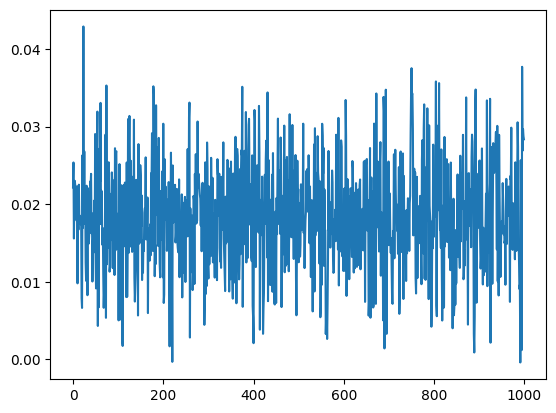

In [153]:
plt.plot(gp[0, :, 0])

In [156]:
gp[2, :, 0].mean()

Array(0.01739998, dtype=float64)

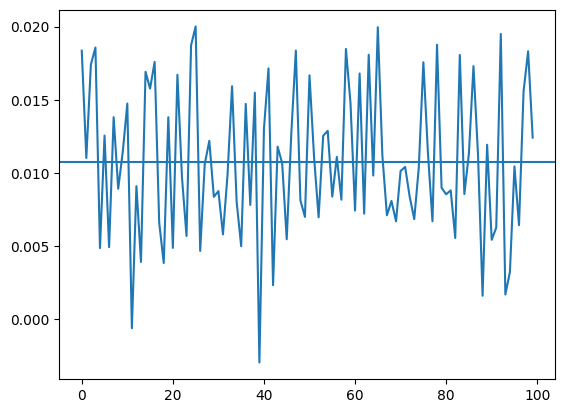

In [158]:
plt.plot(gp[...,0].mean(axis=1))
plt.axhline(gp[...,0].mean(axis=1).mean())

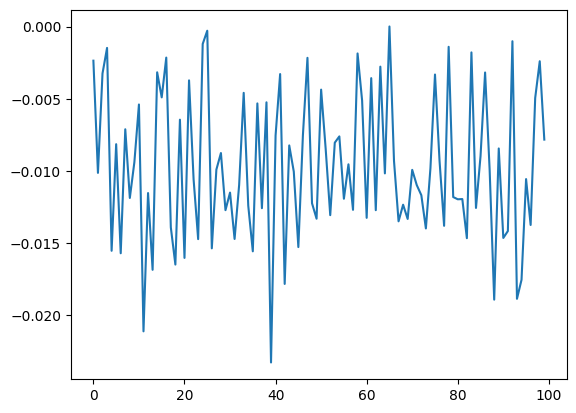

In [151]:
plt.plot(gm[...,0].mean(axis=1))

## 1 galaxies per exp

In [53]:
_func = jit(
    partial(
        get_mbias_mc_same, shape_noise=0.2, n_gals=1, sigma_e_int=0.3
    )
)

In [54]:
_func(42); # jitting

In [55]:
# # seeds = jnp.array([42, 43])
# seeds = jnp.arange(100)
# seeds.shape

In [65]:
# get array of seeds from numpy
rng = np.random.RandomState(11)
seeds = rng.uniform(low=0, high=2**31, size=(100,100,)).astype(int)
seeds = jnp.array(seeds)
seeds.shape

(100, 100)

In [66]:
ms2, gp, gm, _, _, _, _ = vmap(vmap(_func))(seeds)

In [72]:
gp.shape

(100, 100, 1000, 2)

In [67]:
ms2.shape

(100, 100)

(array([3.000e+00, 1.000e+00, 7.000e+00, 2.000e+01, 1.700e+01, 4.800e+01,
        8.100e+01, 1.430e+02, 2.280e+02, 3.730e+02, 5.620e+02, 7.540e+02,
        9.770e+02, 1.178e+03, 1.231e+03, 1.121e+03, 9.990e+02, 7.270e+02,
        5.600e+02, 4.060e+02, 2.070e+02, 1.380e+02, 9.400e+01, 5.700e+01,
        3.000e+01, 1.600e+01, 1.200e+01, 6.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00]),
 array([-0.572706  , -0.54057796, -0.50844991, -0.47632187, -0.44419383,
        -0.41206579, -0.37993774, -0.3478097 , -0.31568166, -0.28355361,
        -0.25142557, -0.21929753, -0.18716948, -0.15504144, -0.1229134 ,
        -0.09078536, -0.05865731, -0.02652927,  0.00559877,  0.03772682,
         0.06985486,  0.1019829 ,  0.13411095,  0.16623899,  0.19836703,
         0.23049507,  0.26262312,  0.29475116,  0.3268792 ,  0.35900725,
         0.39113529,  0.42326333]),
 <BarContainer object of 31 artists>)

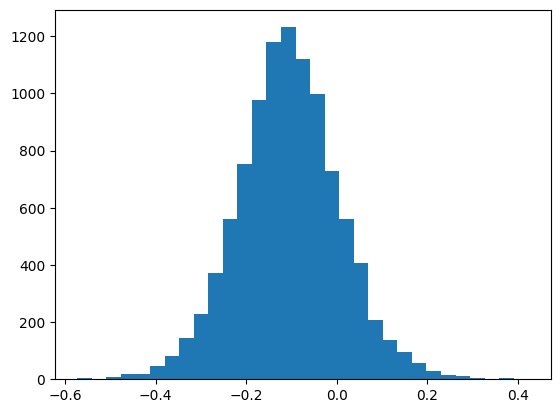

In [68]:
plt.hist(ms2.ravel(), bins=31)

In [70]:
ms2.ravel().mean(), ms2.ravel().std()

(Array(-0.10579699, dtype=float64), Array(0.11302825, dtype=float64))

In [71]:
ms2[0].mean(), ms2[0].std() / np.sqrt(100)

(Array(-0.1011889, dtype=float64), Array(0.01112742, dtype=float64))

## 100 galaxies per exp

In [31]:
_func2 = jit(
    partial(
        get_mbias_mc_same, shape_noise=0.2, n_gals=100, sigma_e_int=0.3
    )
)

In [32]:
rng = np.random.RandomState(2)
seeds = rng.uniform(low=0, high=2**31, size=(100,)).astype(int)
seeds = jnp.array(seeds)
seeds.shape

(100,)

In [33]:
ms3, gp3, gm3, _, _, _, _ = vmap(_func2)(seeds)

In [34]:
ms3.shape

(100,)

## Compare distribution of mean means with distribution of means

In [51]:
ms2.shape

(100, 100)

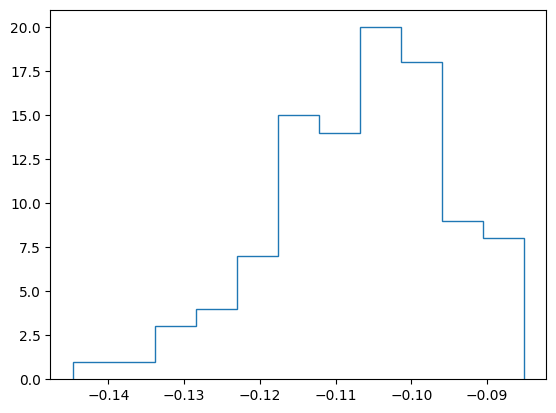

In [52]:
_, bins, _ = plt.hist(ms2.mean(axis=1), bins=11, histtype='step')

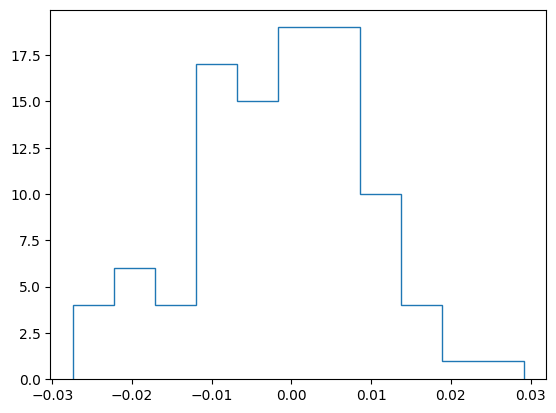

In [37]:
_, bins, _ = plt.hist(ms3, bins=11, histtype='step')

In [17]:
ms2.shape

(1000,)

In [18]:
gp.shape

(1000, 1000, 2)

In [19]:
n_boots = 1000 
ms_means = [] 
for _ in range(n_boots):
    indices = np.random.randint(0, len(gp), (len(gp),))
    _gp = gp[indices][...,0]
    _gm = gm[indices][...,0]
    x = ( _gp.mean(axis=1) - _gm.mean(axis=1)) / 2 / 0.02 - 1  
    ms_means.append(x.mean())


ms_means = np.array(ms_means)


In [20]:
ms_means.shape

(1000,)

(array([  3.,   5.,   9.,  17.,  30.,  37.,  66.,  77., 114., 104., 126.,
         98.,  96.,  71.,  64.,  33.,  23.,  12.,   7.,   2.,   6.]),
 array([-0.014245  , -0.01392342, -0.01360183, -0.01328025, -0.01295867,
        -0.01263708, -0.0123155 , -0.01199391, -0.01167233, -0.01135075,
        -0.01102916, -0.01070758, -0.01038599, -0.01006441, -0.00974283,
        -0.00942124, -0.00909966, -0.00877808, -0.00845649, -0.00813491,
        -0.00781332, -0.00749174]),
 <BarContainer object of 21 artists>)

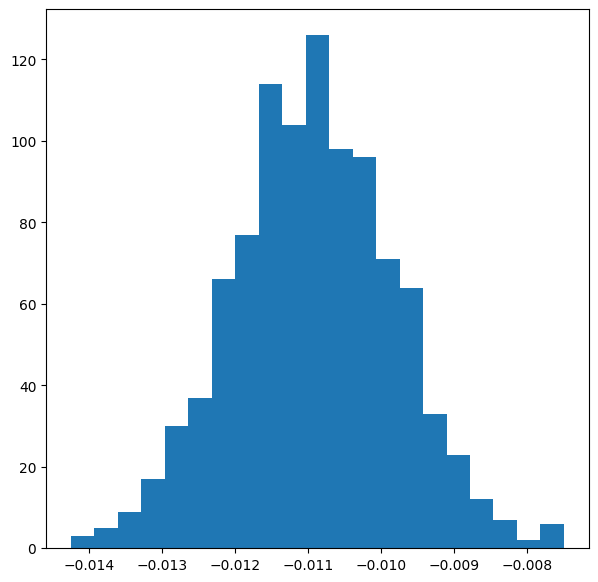

In [21]:
plt.figure(figsize=(7,7))
plt.hist(ms_means, bins=21)

In [22]:
ms2.mean(), ms_means.mean(), ms_means.std()

(Array(-0.010929, dtype=float64),
 np.float64(-0.010926510492936935),
 np.float64(0.0011109987544383527))

### Bootstrap median

In [141]:
gp.shape

(1000, 1000, 2)

In [142]:
ms_meds = (np.median(gp[...,0], axis=1) - np.median(gm[...,0], axis=1)) / 2 / 0.02 - 1

In [143]:
ms_meds.shape

(1000,)

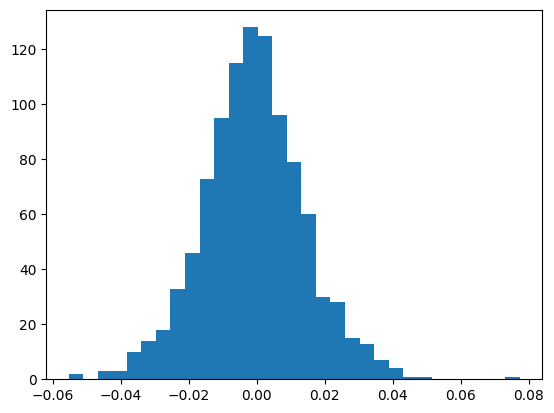

In [156]:
plt.hist(ms_meds, bins=31);

In [157]:
np.median(ms_meds), ms_meds.mean()

(np.float64(-0.001244654623706265), np.float64(-0.0009256293379840051))

In [158]:
ms_meds.shape

(1000,)

In [159]:
n_boots = 10000 
ms_meds2 = [] 
for _ in range(n_boots):
    indices = np.random.randint(0, len(ms_meds), (len(ms_meds),))
    mss = ms_meds[indices]
    ms_meds2.append(np.median(mss))


ms_meds2 = np.array(ms_meds2)


In [160]:
ms_meds2.shape

(10000,)

(array([3.700e+01, 2.030e+02, 2.530e+02, 2.220e+03, 2.881e+03, 2.276e+03,
        1.220e+03, 7.480e+02, 1.460e+02, 1.500e+01, 1.000e+00]),
 array([-3.31733231e-03, -2.89236828e-03, -2.46740425e-03, -2.04244022e-03,
        -1.61747618e-03, -1.19251215e-03, -7.67548122e-04, -3.42584091e-04,
         8.23799405e-05,  5.07343972e-04,  9.32308003e-04,  1.35727203e-03]),
 <BarContainer object of 11 artists>)

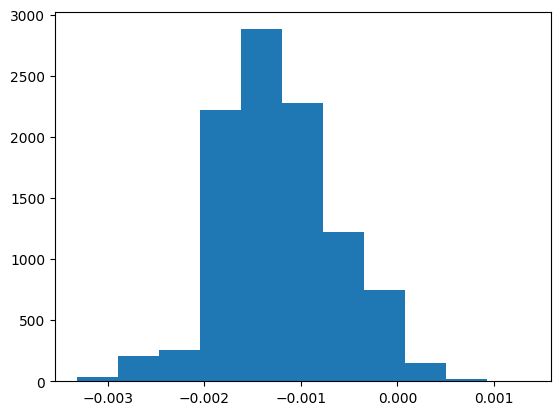

In [165]:
plt.hist(ms_meds2, bins=11)

In [166]:
ms_meds2.mean(), np.median(ms_meds2), ms_meds2.std()

(np.float64(-0.0012087888096637567),
 np.float64(-0.001244654623706265),
 np.float64(0.000598057305031515))

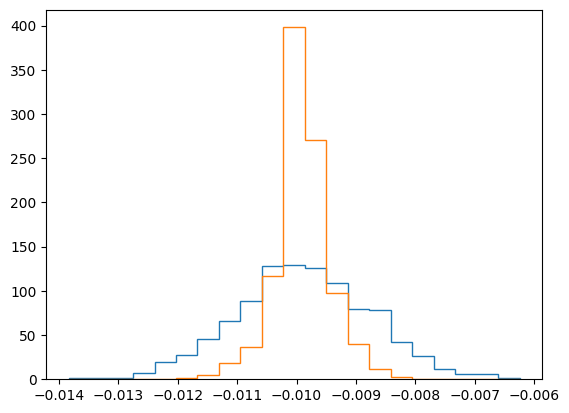

In [112]:
_, bins, _ = plt.hist(ms, bins=21, histtype='step') 
plt.hist(ms2, bins=bins, histtype='step');

In [113]:
ms.std() / ms2.std()

Array(2.47003265, dtype=float64)